# Assignment 7
## Spike train analysis

<div class="alert alert-block alert-warning">
<b>Preparing for this assignment:</b> 

These resources will help you prepare for this assignment. Watch:
<ul>
        <li> <a href="https://youtu.be/smHwRzk81b0?t=688" target="_blank">this video</a> (until 1:01'54) from a MIT course by Prof. Michale Fee to learn about key concepts for spike train analysis: the <b>Poisson process</b>, <b>Fano Factor</b>, <b>inter-spike intervals</b>, <b>cross-correlation</b> and <b>auto-correlation</b>. You do NOT need to follow the equations, just the concepts. </li> 
        <li> <a href="https://youtu.be/m1w7oywzwpA" target="_blank">the first part of this video</a> (until 17'15) to learn about Generalized Linear Models (GLM) and in particular about the <b>Poisson GLM for spike count regression</b>. Things get a bit more mathy after 10'12: again, forget about the equations if you cannot follow them and try to focus on the concepts. Remember that we have used GLMs previously: linear regression and logistic regressions are classes of GLMs, for continuous and binary data respectively.</li>
</ul>
</div>

# 0. Introduction
In this assignment we will learn about tools to visualize, analyze and model spiking data. Spike trains are different from typical type series such as EEG or fMRI data as they consist of the list of timings for discrete events (action potentials). The same tools can be applied to analyze other event data such as eye saccades, or lever presses in animal conditioning experiments.

The data will be used are spiking activity collected from **one neuron of the dorso-medial striatum** (a structure of the basal ganglia) of one rat while it performs a **perceptual decision-making task**. In one of the analysis we will also look at another neuron recorded during the same experimental session. The (complex) details of the behavioral protocol are available in this [publication](https://www.nature.com/articles/s41467-020-14824-w), but for all we care here **the animal basically has to go to a left or right port depending on whether the dominant tone in an acoustic stimuli is high frequency or low frequency**. The difficulty of the trial is manipulated in a variable called *stimulus evidence*, bounded between -1 and 1. Its value is +1 for pure high-frequency stimulus (i.e. clear evidence towards the rightward response), -1 for pure low-frequency stimulus  (i.e. clear evidence towards the leftward response), and values in between for a mix of low-frequency and high-frequency stimulus (for example stimulus 0 means no evidence at all for either response).

Our goal here is to study the basic characteristics of this neuron spiking activity and **whether the neuron activity encodes for the stimulus information and/or the response of the animal**.

Let us first import the typical packages (plus some others we will need along the way).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import expon, norm # for exponential and gaussian distributions
from scipy.signal import correlate, correlation_lags # for auto-correlation / cross-correlation

Now we will **load the spiking data and the behavioral data**. The spiking data will be loaded as a simple numpy array which represents the timing (in seconds) of all spikes for this neuron during this session. The behavioral data is loaded as a dataframe, comprising the following variables: `Stimulus` (stimulus evidence), `Response` (1: left; 2:right), `Outcome` (0: incorrect, 1:correct), `tResponse` (the timing of the onset of response w.r.t. the onset of the session, in seconds). This last variable will help us isolate the neuron spikes that occur around each trial.

In [2]:
# load spiking data as numpy array
SpikeTimes =  np.loadtxt("https://raw.githubusercontent.com/wimmerlab/MBC-DataAnalysis/main/A7_SpikeTrainAnalysis/Neuron1_Spike.csv")

# load behavioral data as dataframe
df = pd.read_csv("https://raw.githubusercontent.com/wimmerlab/MBC-DataAnalysis/main/A7_SpikeTrainAnalysis/BehavioralData.csv")
df.head()

,Stimulus,Response,Outcome,tResponse
0,0.4415,1,0,55.617699
1,0.4415,2,1,60.286934
2,-0.4415,1,1,63.447197
3,1.0000,2,1,66.404634
4,0.0000,1,1,69.485402


# 1. Basic measures
## 1.1 Displaying spikes

**How many spikes did we record in total for this neuron?**

In [3]:
nSpike = len(SpikeTimes)
print(nSpike, "spikes")

7747 spikes


**Let's plot the spike times in a certain window**, to get a rough idea of how this neuron fires.
Adjust the window to look at the activity at different time scales.

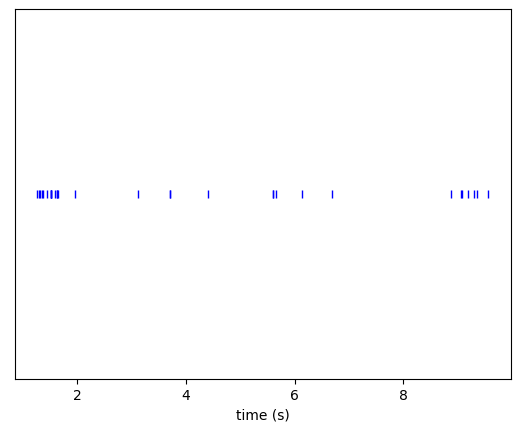

In [4]:
# Define window (start time - end time)
win = (0,10)

# Select all spikes within this window
SpikesInWindow = SpikeTimes[ (SpikeTimes>=win[0]) & (SpikeTimes<=win[1])]

# plot as vertical ticks 
yPos = np.zeros_like(SpikesInWindow) # y-value will be a constant value for all spikes
plt.plot(SpikesInWindow, yPos,'b|');

# add labels
plt.xlabel('time (s)');
plt.yticks([]);

## 1.2 Computing spike rate
**Compute the average spike rate of this neuron** over the whole session, i.e. the total number of spikes divided by the length of the time window (in seconds). Here you can approximate the length of the session as the duration elapsed between the first and last spikes.

In [5]:
# length of window
WinLength = SpikeTimes[-1]-SpikeTimes[0]

# spike rate
SpikeRate = len(SpikeTimes)/WinLength

print("Spike rate: ",SpikeRate, " Hz")

Spike rate:  1.8817362794657804  Hz


## 1.3 Distribution of inter-spike intervals
**Plot the distribution of inter-spike intervals** (i.e. the time intervals between two successive spikes). Hints: use the function `np.diff`; to plot a distribution, use the function `plt.hist` and set the parameter `density` to `True`.

We know that if the neuron spikes according to an homogeneous Poisson process, this distribution should be exponential (with a *scale* equal to the inverse of the neuron spike rate).
**Plot the prediction for the ISI distribution for the Poisson process on top of the histogram.**

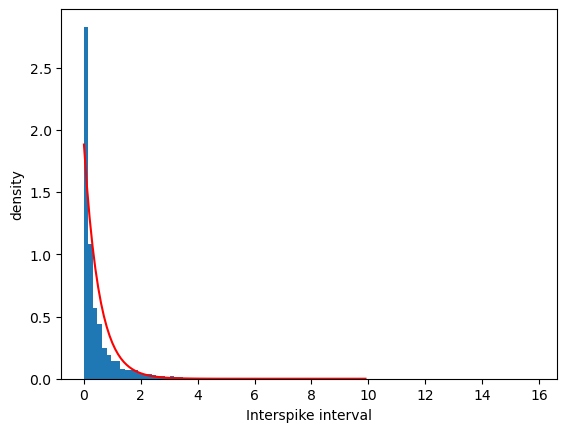

In [6]:
# compute the array inter-spike intervals
ISI = np.diff(SpikeTimes)

# plot the experimental distribution of ISI (adjust the number of bins)
plt.hist(ISI, 100, density = True, label = 'experimental')

# scale of the Poisson process
scale =1/SpikeRate

# array of ISI values for which we want to compute the predicted pdf, from 0 to 10 seconds with small steps
ISIrange = np.arange(0,10,.1)

# corresponding values for probability distribution
p_Poisson = expon.pdf(ISIrange, scale=scale)

# plot as red curve
plt.plot(ISIrange, p_Poisson, 'r-', label='Poisson'); 

# add label
plt.xlabel('Interspike interval');
plt.ylabel('density');
plt.legend;


**Interpret**

*The experimental distribution decays very fast, as predicted by the Poisson process. However it does not strictly follow an experimental decay: there are more very short ISIs (< 100 ms) than expected by the Poisson process, and less longer ISIs. In other words the neuron has more frequent periods of bursting than expected. It does not follow an homogeneous Poisson process (which is good because if it did, it would not encode anything).*

# 2. Auto-correlation and cross-correlation

## 2.1 Binnning spike activity

We want to understand better the dynamics of spiking activity, using the tool of auto-correlation. As explained in the first video, auto-correlation tells us about the **time scales that regulate spiking activity**: whether there are periods of higher firing (due to either external factors, i.e. the presence of a stimulus to which the neuron responds; or internal factors, i.e. increased excitability in the local neural network), and the time scales of this period. Remember: the auto-correlation of the (really dull) homogeneous Poisson process is completely flat at 0 (except for the value at zero-lag, as a variable is always correlated with itself).

Auto-correlation (or cross-correlation) tools do not work directly on spiking data but on discrete time series (like EEG,...). So our first step is to "bin spikes", i.e. define regular time bins of a certain duration and compute the number of spikes in each bin. This process is illustrated in the image below. **Bin the neuron spikes with a time resolution of 10 ms** (i.e. time bin duration = 10 ms). Hint: this actually corresponds to computing the histogram of spike counts (the number of spike counts in each bin), so you can use `np.histogram`.

![Task](https://github.com/wimmerlab/MBC-DataAnalysis/blob/f68a033829be4bf9b2d36ab2e968ea5c6fac0f7e/A7_SpikeTrainAnalysis/Spike_Train_Binning.png?raw=true)

In [7]:
# define time bin duration (in SECONDS!!)
dt = 1e-2

# define our time grid, i.e. an array of values spanning all the recording time interspersed with dt
time_grid = np.arange(np.min(SpikeTimes),np.max(SpikeTimes),dt)

# compute the number of spikes in each bin
SpikeCount, _ = np.histogram(SpikeTimes,bins=time_grid)

# display first 50 values
SpikeCount[:50]

array([1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [8]:
# make sure it worked
assert(SpikeCount[24]==2)

## 2.2 Auto-correlation (Optional)

Now **compute the auto-correlation of the signal** using the function `correlate` from the `scipy` package.
We need to compute the measure on **centered data** (i.e. removing the mean of the value to the spike count data) so that the null values correspond to 0.

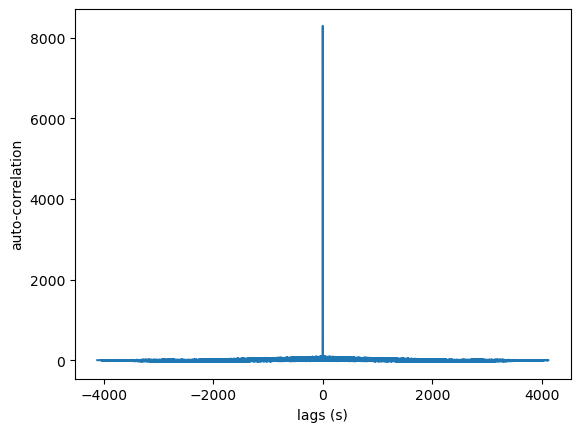

In [9]:
# center the spike count data, i.e. remove its mean value
SpikeCountCentered = SpikeCount - np.mean(SpikeCount)

# compute the auto-correlation (i.e. cross-correlation between the two same signals)
AC = correlate(SpikeCountCentered, SpikeCountCentered)

# this provides the values of the corresponding lags
nBin = len(SpikeCountCentered) # number of spike bins
lags = correlation_lags(nBin, nBin)

# lags are given in time steps, convert to seconds
lags = lags*dt

# plot
plt.plot(lags, AC);
plt.xlabel('lags (s)');
plt.ylabel('auto-correlation');

It's nice to have made it, but we can't really see anything because the auto-correlation covers the whole range of timing in the data (up to 4000 seconds, i.e. over an hour of recording). In reality we don't expect the most significant dynamics to last more than one second, so let's **plot the auto-correlation only for lags up to one second**.

Moreover, the peak corresponds to the value at exactly lag-zero, which is very not informative because at lag-zero one variable is always maximally correlated to each other. So we will **change this value to a nan** (use `np.nan`) to avoid distorting the scale along the y-axis.

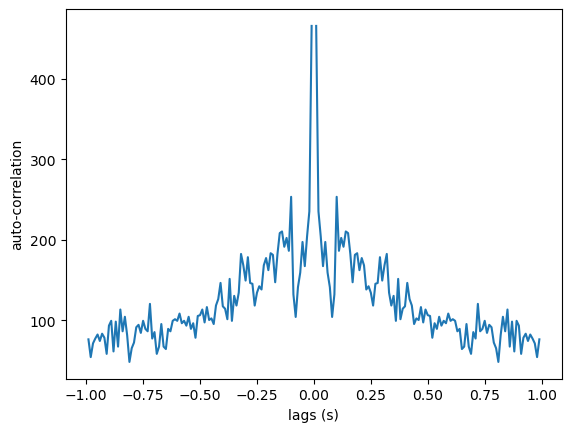

In [10]:
# define maximal lag
MaxLag = 1

# set value at lag 0 to nan (we need to convert first to floater)
AC = np.float64(AC)
AC[lags==0] = np.nan

# boolean array for all lags smaller than maximal lag (in absolute value)
mask = np.abs(lags)<MaxLag

# plot the AC again
plt.plot(lags[mask], AC[mask]);
plt.xlabel('lags (s)');
plt.ylabel('auto-correlation');

**Interpret the plot.**

*We see that the auto-correlation is positive for short values and decays smoothly at a time scale of 400 ms approx. This means that spiking activity alternates between periods of high firing and low firing at a time scale of 400 ms approx. Because this time scale corresponds more or less to the time scale of trials, it may be that this neuron is sensitive to one particular event that occurs on every trial, creating this auto-correlation.*

## 2.3 Cross-correlation

Auto-correlation is like cross-correlation applied to the same signal, but what is cross-correlation? Cross-correlation allows to look for **interactions between two signals not only at corresponding times, but also with certain time lags**. For example, if one neuron receives excitatory synaptic input from another neuron, on general that higher activity in the pre-synaptic neuron will be followed with higher activity in the post-synaptic neuron (with a certain lag set by synaptic dynamics). This will be directly visible in the cross-correlogram as a bump occurring at the corresponding lag.
**Warning!** while it is tempting to interpret a cross-correlogram as a causal interaction between the two signals, cross-correlograms can also signal shared influence impacting both signals. In fact in neural activity, the probability that two neurons are connected by a direct synapse is rather low, so more often than not a cross-correlogram reveals the influence from shared incoming neural signals.

Load the spiking activity from neuron 4 and **compute the cross-correlogram between the two neurons**.
We will first **define a function to compute and plot the cross-correlogram**.

In [11]:
# First, define a function to plot the cross-correlation between two signals
def plot_crosscorrelation(X, Y, dt, MaxLag):
    """
    Plots the cross-correlation between two signals 
    Args:
       X (array): first signal (time series)
       Y (array): second signal (time series)
       dt (float): time resolution (in sec)
       MaxLag (float): maximum lag to be plotted (in sec)
    """
    # center the two signals X and Y
    X = X - np.mean(X)
    Y = Y - np.mean(Y)
    
    # compute the cross-correlation and lags
    CC = correlate(Y, X)
    lags = correlation_lags(len(X), len(Y))
    
    # convert lags to seconds
    lags = lags*dt
    
    # define mask for lags below value set by MaxLag
    mask = np.abs(lags)<MaxLag

    # plot
    plt.plot(lags[mask], CC[mask]);
    plt.xlabel('lags (s)');
    plt.ylabel('cross-correlation');

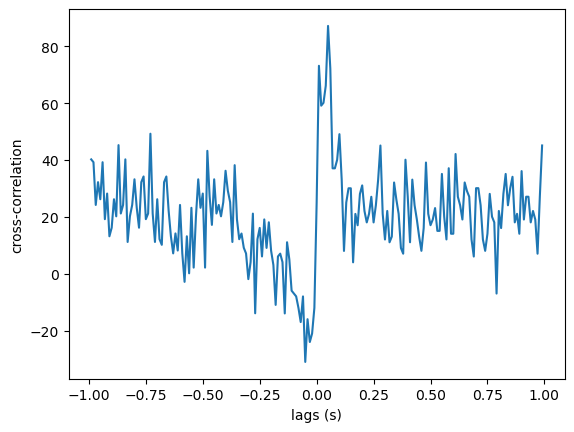

In [12]:
# Load data from neuron 4
SpikeTimes4 =  np.loadtxt("https://raw.githubusercontent.com/wimmerlab/MBC-DataAnalysis/main/A7_SpikeTrainAnalysis/Neuron4_Spike.csv")

# Bin spikes (using same time grid as for neuron 1)
SpikeCount4,_ = np.histogram(SpikeTimes4,bins=time_grid)

# use function created above to plot the cross-correlation
plot_crosscorrelation(SpikeCount, SpikeCount4, dt, MaxLag)


**Interpret.**

*There are some significant components, notably at a very fast time scale (< 200 ms), where indicating that perhaps one neuron is lagging a bit behind the other neuron. Given the time scale, this could happen for example if one neuron is sensitive to an event, and the other to another event that immediately follows (e.g. stimulus and responses). It could also be due to local synaptic interactions. We would need to perform some permutation tests to make sure these fluctuations are truly significant.*

## 2.4 (Optional) Cross-correlation on synthetic data
To understand better how cross-correlation, let's use it on simulated data. 
First let us simulate one neuron that spikes as a Poisson process with the same rate as neuron 1 in our experimental data.

**Simulate the spike counts in each bin for this synthetic neuron.** A Poisson process can be simulated using `np.random.poisson`.

In [13]:
# average spike count across time bins
AverageCount = np.mean(SpikeCount)

# generate an array of spike count following Poisson process with corresponding rate
SyntheticSpike = np.random.poisson(AverageCount, len(SpikeCount))

# display first 100 bins
SyntheticSpike[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

**Now simulate the activity of a second (extremely over-simplified!) neuron receiving input from the first neuron and which outputs the exact same spike train as the input with a certain delay of 30 ms (so 3 time bins).**

In [14]:
# Define lag (in time bins)
lag = 3

# Define activity of second neuron (Hint: we just need to add zeros at the beginning of the spike count array, and remove the corresponding values at the end)
SyntheticSpike2 = np.concatenate((np.zeros(lag), SyntheticSpike[:-lag-1]) )

# display first 100 bins (check that indeed spikes in neuron 1 are lagged in neuron 3 by 3 bins)
SyntheticSpike2[:100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

**Now plot the cross-correlation between the spike counts of the two neurons** (using our previously defined function).

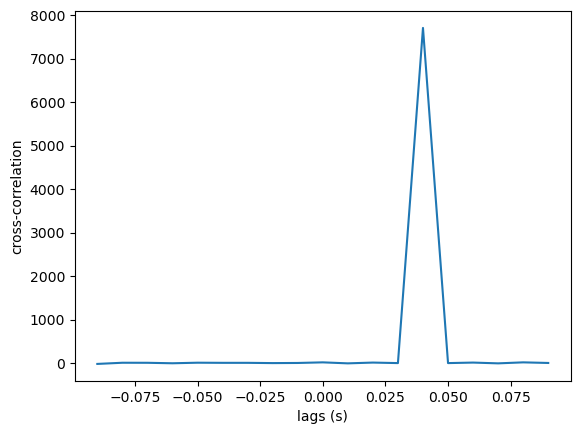

In [15]:
# Use  function
plot_crosscorrelation(SyntheticSpike, SyntheticSpike2, dt, .1)

**Vary the lag and compute the cross-correlation again. Interpret.**

*We see a peak which is exactly at the lag (in seconds) of neuron 2 w.r.t neuron 1.* **The cross-correlogram allows to identify the precise temporal relationships between the two signals.**

# 3. Rastergram and PSTH


## 3.1 Grouping spiking activity per trial

It is now time to start **relating spiking activity to the behavior**.
First, we need to extract the spiking activity corresponding to each trial. 
More precisely, on each trial, we want to **identify all the spikes in a certain window around the onset of the animal response and re-reference the spike times w.r.t. this response onset** (i.e. t=0 now corresponds to response onset). This is similar to the epoching procedure to extract evoked activity from EEG recordings. This process is illustrated below (with a window from 0 to $T$).

![Task](https://github.com/wimmerlab/MBC-DataAnalysis/blob/f68a033829be4bf9b2d36ab2e968ea5c6fac0f7e/A7_SpikeTrainAnalysis/Extracting%20trial-based%20spike%20train.png?raw=true)

We will use a window from 500 ms prior to response onset to 1000 ms after response onset.
**Add the spike train per trial as a new variable to our dataframe** (under the name `Spikes`).

In [16]:
# define window
window = (-0.5,1)

# number of trials
nTrial = df.shape[0]

# initialize a list with the spikes corresponding to each trial
SpikesPerTrial = []

#loop through trials
for t in range(nTrial):
    
    # re-reference time so that time=0 corresponds to tResponse in this trial
    SpikeRereferenced = SpikeTimes - df.tResponse[t]
    
    # select only spikes in window
    bool = (SpikeRereferenced>=window[0]) & (SpikeRereferenced<=window[1])
    SpikeInThisWindow = SpikeRereferenced[bool]
    
    # add to SpikesPerTrial
    SpikesPerTrial.append(SpikeInThisWindow)

# add to the dataframe
df['Spikes'] = SpikesPerTrial
df.head()

,Stimulus,Response,Outcome,tResponse,Spikes
0,0.4415,1,0,55.617699,"[0.07650100000000037, 0.6720010000000016, 0.78..."
1,0.4415,2,1,60.286934,"[0.21949966666660004, 0.22239966666660393, 0.2..."
2,-0.4415,1,1,63.447197,"[-0.49763066666660194, 0.8287693333334047]"
3,1.0000,2,1,66.404634,"[0.24616633333340587, 0.30509966666670607, 0.3..."
4,0.0000,1,1,69.485402,"[0.23546500000009019, 0.2489650000000978]"


## 3.2 Rastergram
Now we can see how the activity of the neuron evolves within each trial by plotting a rastergram (or rasterplot).
In a rastergram, x-axis denotes time, y-axis denotes the different trials, and each spike is noted by a vertical tick (or point). A rastergram can also be used to plot the activity of a population if neurons across a single trial, and so the vertical axis denotes neuron identity.
**Plot the rastergram for this neuron.**
Add a vertical line to mark response onset.

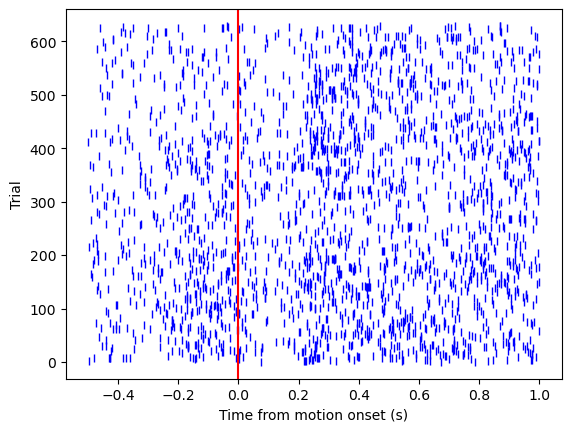

In [17]:
# loop through trials
for t in range(nTrial):
    
    # number of spikes in corresponding window    
    nSpikes = len(df.Spikes[t])
    
    # plot spike as blue vertical ticks
    plt.plot(df.Spikes[t], t*np.ones(nSpikes),'b|');

# add line at response onset
plt.axvline(0,color='r');

# add labels
plt.xlabel('Time from motion onset (s)');
plt.ylabel('Trial');

**Interpret.**

*We see a lot of variability of neuron firing across trials. But importantly, in many trials we also see an increase of activity starting 200 ms approx after motion onset (although that increase does not seem to be present in all trials).*

## 3.3 Rastergram per condition
The rastergram can also be separated by behavioral condition, to inspect visually whether the neural activity is related to some behavioral condition. 
**Plot the rastergram separately for trials with leftward and rightwards responses.**
(In practice, we use a different color for each type of response and we plot  trials in one condition above trials in the other condition, see an example [here](https://i.gyazo.com/06659ec5318b06dd3d82ef2fbd15948c.png) ).

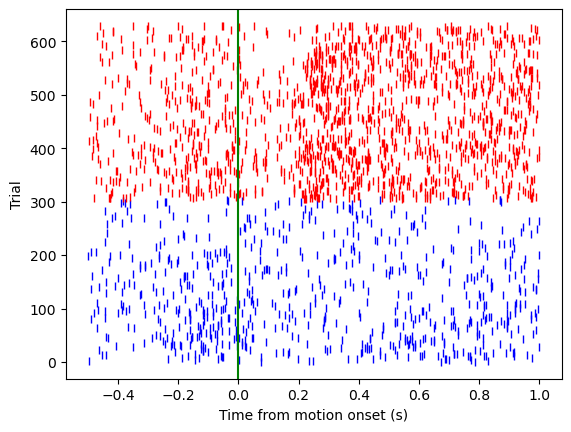

In [18]:
# identify trials with leftwards response (i.e. =1)
TrialIndexResp1 = np.where(df.Response==1)[0]

# number of leftward responses
nResp1 = len(TrialIndexResp1)

# loop through leftward response trials
for t in range(nResp1):
    # corresponding index of trial in list of ALL trials
    tt = TrialIndexResp1[t]
    
    # plot spikes for this trial (in blue)
    nSpikes = len(df.Spikes[tt])
    plt.plot(df.Spikes[tt], t*np.ones(nSpikes),'b|');


# repeat the same for trials with rightwards responses (do not forget to change the color and add a vertical offset)
TrialIndexResp2 = np.where(df.Response==2)[0]
nResp2 = len(TrialIndexResp2)

for t in range(nResp2):
    tt = TrialIndexResp2[t]
    nSpikes = len(df.Spikes[tt])
    
    # we're offsetting vertically by nResp1 so that these trials are shown on top
    plt.plot(df.Spikes[tt], (nResp1+t)*np.ones(nSpikes),'r|');    

    
# add line at response onset
plt.axvline(0,color='g');    
plt.xlabel('Time from motion onset (s)');
plt.ylabel('Trial');

**Interpret.**

*Now we see very clearly that **the increase in activity after motion onset is specific to rightward responses**.*

## 3.4 PSTH
We can confirm our visual impression of rastergrams by plotting the Peri-Stimulus Time Histogram (or PSTH), which is an ugly name to say that we basically average the spike counts across trials, after binning the spikes using a certain window. By averaging activity across trials, we also gain statistical power to detect consistent changes in activity at a given time in a given condition.

First, **define a function that computes the PSTH for a given array of spike trains**. For this analysis we don't care about which trial each spike is associated to, only their timing, so we can concatenate spike trains across trials using `np.concatenate`.

In [19]:
# This function will compute the PSTH of a given array of spike trains
def compute_PSTH(S, dt, Tini, Tend):
    """
    Computes the PSTH. 
    Args:
       S (list of ndarrays): list of spike trains (one array per trial)
       dt (float): time resolution for PSTH
       Tini (float): initial time of PSTH
       Tend (float): final time of PSTH
    Returns:
       ndarray: PSTH
       ndarray: corresponding time bin centers
    """
    
    # number of trials in the array
    nTrial = len(S)
    
    # concatenate all spikes in one single array
    all_spike = np.concatenate(S)
        
    # define the time grid, starting at Tini until Tend with dt resolution
    time_grid = np.arange(Tini,Tend,dt)

    # compute the spike counts in all bins defined by the time grid
    PSTH,_ = np.histogram(all_spike,bins=time_grid)
    
    # normalize the counts by number of trials and size of time bin so that PSTH is defined in spikes/sec
    norm_factor = nTrial*dt
    PSTH = PSTH / norm_factor

    # remove last element in time grid to match length with PSTH
    time_grid = time_grid[:-1]
    
    return PSTH, time_grid

**Plot the PSTH separately for leftward and rightward trials** (as two curves on the same plot).

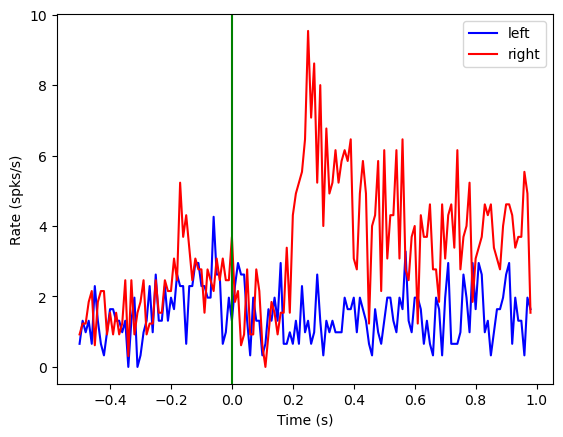

In [20]:
# time resolution
dt = .01

# spike trains for leftward and rightward response trials
# we need '.values' to convert dataframe back to array
Spikes_resp1 = df.Spikes[df.Response==1].values
Spikes_resp2 = df.Spikes[df.Response==2].values

# compute PSTH using the function above
PSTH_Resp1, PSTH_time_grid = compute_PSTH(Spikes_resp1, dt, window[0], window[1])
PSTH_Resp2, PSTH_time_grid = compute_PSTH(Spikes_resp2, dt, window[0], window[1])

# plot
plt.plot(PSTH_time_grid, PSTH_Resp1, 'b-', label = "left");
plt.plot(PSTH_time_grid, PSTH_Resp2, 'r-', label = "right");

# vertical line
plt.axvline(0,color='g');    

# add labels
plt.ylabel('Rate (spks/s)');
plt.xlabel('Time (s)');
plt.legend();

**Interpret**.

*Now we see very clearly the specific increase in activity in rightward responses.*

## 3.5 Smooth PSTH (Optional)
Because very fast changes in the spiking activity are often irrelevant, **PSTHs are often smoothed by convolving it with a gaussian kernel**. The width of the gaussian controls the time scale of smoothing. The functions below define a gaussian kernel and smooth a signal using this gaussian kernel.

In [21]:
def gaussian_kernel(sigma):
    """
    Defines a gaussian kernel. 
    Args:
       sigma (float): width of gaussian kernel.
    Returns:
       ndarray: gaussian kernel
    """
    
    #define the length of the kernel
    kernel_length = 5*sigma
    
    # define indices for the kernel
    time_vec = np.arange(-3*sigma,3*sigma) 

    #generate a Gaussian kernel (a value for each index)
    K = norm.pdf(time_vec, loc=0, scale=sigma)
    
    #Normalize the kernel to have area=1 to maintain the same rate units
    K = K/np.sum(K)
    
    return K

    
def smooth_function(X, dt, sigma):
    """
    Smooths any time series with a gaussian kernel. 
    Args:
       X (ndarray): time series.
       dt (float): time resolution of time series
       sigma (float): width of gaussian kernel.
    Returns:
       ndarray: Smoothed time series
    """
    
    # convert sigma of kernel to time bins
    sigma_timebins = int(sigma/dt)

    # define gaussian kernel
    K = gaussian_kernel(sigma_timebins)
    
    # convolve signal with kernel
    Xsmooth = np.convolve(X, K, 'same')

    return Xsmooth

This function simply plots the gaussian kernel, so you get an idea.

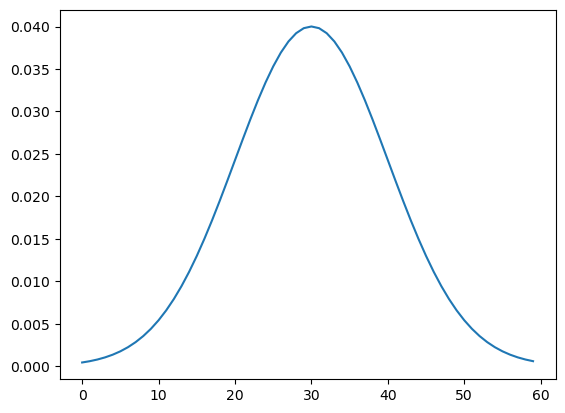

In [22]:
sigma = 10 # here define in time bins

plt.plot(gaussian_kernel(sigma));

Now **apply the function to smooth the PSTHs**. Choose an appropriate value for sigma.

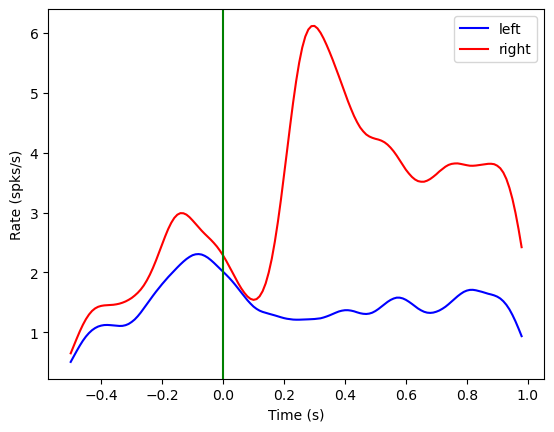

In [23]:
 #define the temporal width (in SECONDS) of the Gaussian kernel to filter the PSTH
sigma_kernel = .05

# use the function above to convolve the two PSTHS
SmoothPSTH_Resp1 = smooth_function(PSTH_Resp1, dt, sigma_kernel)
SmoothPSTH_Resp2 = smooth_function(PSTH_Resp2, dt, sigma_kernel)

# plot the smoothed PSTHs
plt.plot(PSTH_time_grid, SmoothPSTH_Resp1, 'b-', label = "left");
plt.plot(PSTH_time_grid, SmoothPSTH_Resp2, 'r-', label = "right");

# vertical line
plt.axvline(0,color='g');  

plt.ylabel('Rate (spks/s)');
plt.xlabel('Time (s)');
plt.legend();

# 4. Fano Factor

The Fano Factor is a **measure of the reliability of the spiking process**. In other words it tells us how stochastic spiking is. It is computed on spike counts on a window long enough to have on average more than one spike. The value is $FF = \frac{V}{M}$, where $V$ is the variance of the spike count across trials (windows), and $M$ is the mean of the spike count across trials.The homogeneous Poisson process has a Fano Factor equal to 1. Larger values means even more random than that (i.e. highly bursting), lower values means more regular firing (i.e. periodic).
The Fano Factor must be computed after taking into account the factors that we know affect the activity of the neuron (and so introduce variability in the spiking). Which is why we will compute separately for leftward and rightward responses.

## 4.1
**Compute the number of spikes in each trial in a window of 500 ms starting at response onset**, and as a variable to the dataframe.

In [24]:
# Define window
MotorWindow = (0,.5)

# Pre-allocate spike count array
SC = np.zeros(nTrial)

#loop through trials
for t in range(nTrial):
    # boolean array which is true if the spike is in the 500-ms window
    inWindow = (df.Spikes[t]>=MotorWindow[0]) & (df.Spikes[t]<=MotorWindow[1])
    
    # count spikes verifying this condition
    SC[t] = np.sum(inWindow)

# add to dataframe
df['SpikeCount'] = SC

df.head()

,Stimulus,Response,Outcome,tResponse,Spikes,SpikeCount
0,0.4415,1,0,55.617699,"[0.07650100000000037, 0.6720010000000016, 0.78...",1.0
1,0.4415,2,1,60.286934,"[0.21949966666660004, 0.22239966666660393, 0.2...",4.0
2,-0.4415,1,1,63.447197,"[-0.49763066666660194, 0.8287693333334047]",0.0
3,1.0000,2,1,66.404634,"[0.24616633333340587, 0.30509966666670607, 0.3...",3.0
4,0.0000,1,1,69.485402,"[0.23546500000009019, 0.2489650000000978]",2.0


## 4.2 (Code is optional)
**Compute separately for leftward and rightward responses the average spike count, variance of the spike count and Fano Factor. Plot all values in bar plots.** (Note: the variance is computed using `np.var`.

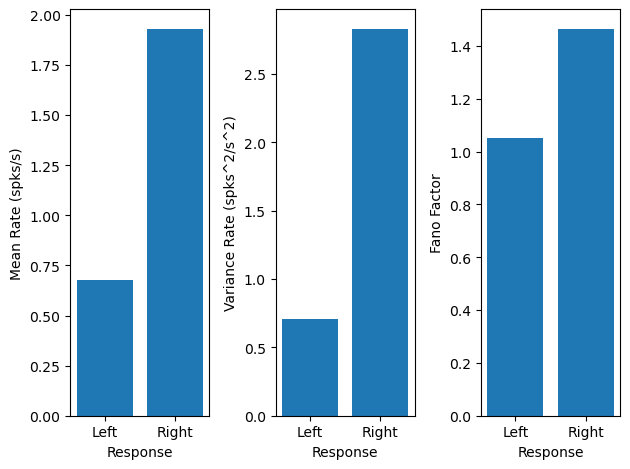

In [25]:
# pre-allocate numpy arrays for mean, variance of spike counts and Fano Factor
MeanCount = np.zeros(2)
VarCount = np.zeros(2)
FanoFactor  = np.zeros(2)

# for each type of response (leftward/rightward)
for r in range(2):
    
    # corresponding trials (mind the values taken by df.Response!)
    mask = df.Response==r+1
    
    # corresponding spike counts
    SpikeCountResp = df.SpikeCount[mask]
    
    # mean values
    MeanCount[r] = np.mean(SpikeCountResp)
    
    # variance
    VarCount[r] = np.var(SpikeCountResp)
    
    # Fano Factor
    FanoFactor[r] = VarCount[r] / MeanCount[r]

# reponse label
RespLabel = ('Left','Right')

# plot mean rate
plt.subplot(1,3,1)
plt.bar(RespLabel, MeanCount)
plt.ylabel('Mean Rate (spks/s)');
plt.xlabel('Response')

# plot variance
plt.subplot(1,3,2)
plt.bar(RespLabel, VarCount)
plt.ylabel('Variance Rate (spks^2/s^2)');
plt.xlabel('Response')

# plot Fano Factor
plt.subplot(1,3,3)
plt.bar(RespLabel, FanoFactor)
plt.ylabel('Fano Factor');
plt.xlabel('Response')

plt.tight_layout()

**Interpret.**

*The values of the Fano Factor are close to 1, and even larger in rightward responses 2. This means a lot of variability in neural spiking, which may be due to other experimental conditions that we are not controlling for.*

# 5. Spike count regression

In this last part, we will see how we can perform **regression on spike counts data to determine the variables that a neuron is encoding**. This will be done using **Poisson regression** or **Poisson GLM**, which is the standard regression for count data (just as logistic regression is for binary data).

## 5.1 Logistic regression

But first, let us do look at how the animal behaves during this session. We have copied below (and adapted, thank you) the functions used in Assignments 3-4 to plot and fit a psychometric curve. Read through them if you need a little refresh on logistic regression.

In [26]:
def logistic(x):
    """
    Returns the output of the logistic function for the given input value (float or array-like).
    """
    y = 1 / (1 + np.exp(-x))
    return y

def psychometric_model(d, w0, w1):
    """
    Compute the psychometric function based on a simple logistic model. 
    Args:
       d (ndarray): input values.
       w0 (float): intercept for logistic regression.
       w1 (float): slope for logistic regression.
    Returns:
       ndarray: The `y` data points of the psychometric function. 
          In our case, this corresponds to the probability of CCW responses.
    """
    p = logistic(w0 + w1*d)
    return p

def plotcurve(df, color):
    """
    Plot the fitted psychometric curve with experimental datapoints on top. 
    Args:
       df (dataframe): experimental data
       color (string): color of the datapoints and fitted line
    """

    mod = smf.glm(formula='Response ~ Stimulus', data=df, family=sm.families.Binomial())
    res = mod.fit()
    
    myx = np.linspace(-2,2,100)
    yfit=res.predict(pd.DataFrame({'Stimulus': myx})) #yfit = res.predict(exog={'probe_target':myx})

    # plot the psychometric function (fit)
    plt.plot(myx,yfit,'-', color=color,label='fit')
    
    # plot the psychometric curve (datapoints)
    df.groupby('Stimulus').Response.agg(('mean','sem')).plot(yerr='sem', color=color, fmt = 'o', ax=plt.gca(), label='data');

Before applying logistic regression, we need to make sure that our dependent variable (here the response) is coded as 0s and 1s. Now this is not the case. **Change the values so that 1s mark rightward responses.**

In [27]:
# subtract 1, so 2 becomes 1 (right) and 1 becomes 0 (left)
df.Response = df.Response-1

#check
df.head()

,Stimulus,Response,Outcome,tResponse,Spikes,SpikeCount
0,0.4415,0,0,55.617699,"[0.07650100000000037, 0.6720010000000016, 0.78...",1.0
1,0.4415,1,1,60.286934,"[0.21949966666660004, 0.22239966666660393, 0.2...",4.0
2,-0.4415,0,1,63.447197,"[-0.49763066666660194, 0.8287693333334047]",0.0
3,1.0000,1,1,66.404634,"[0.24616633333340587, 0.30509966666670607, 0.3...",3.0
4,0.0000,0,1,69.485402,"[0.23546500000009019, 0.2489650000000978]",2.0


Now **use the functions above to plot the psychometric curve.**

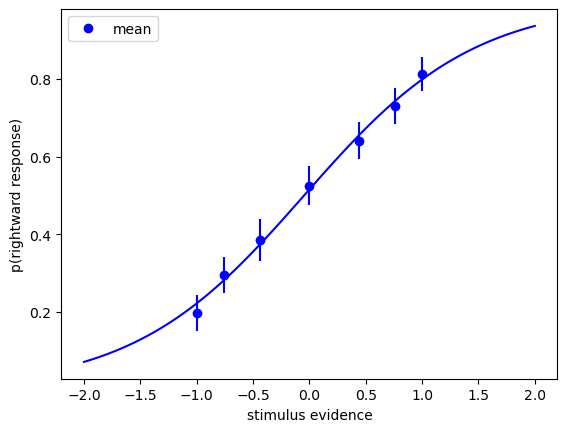

In [28]:
plotcurve(df, 'b')

plt.xlabel('stimulus evidence');
plt.ylabel('p(rightward response)');

**Interpret.**

*The behavior of the animal is well captured by the simple logistic regression model: positive stimulus evidence leads to higher proportion of rightward responses, and negative evidence leads to higher proportion of leftward responses. So the rat performs the task quite well.*

## 5.2 Simple Poisson regression
Now we are ready for a simple regression of the neuron spike count (in the 500-ms response window).
**Regress the spike counts against stimulus evidence using a Poisson GLM**. In practice, this is done just like logistic regression using `glm` from `statsmodel` package, but setting the family to `Poisson` instead of `Binomial`.

In [29]:
mod = smf.glm(formula='SpikeCount ~ Stimulus', data=df, family=sm.families.Poisson())
res = mod.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             SpikeCount   No. Observations:                  630
Model:                            GLM   Df Residuals:                      628
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1012.3
Date:                Tue, 27 Feb 2024   Deviance:                       1018.3
Time:                        09:38:28   Pearson chi2:                     996.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.06005
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2538      0.036      7.136      0.0

**Interpret.**

*It seems that the neuron activity is selective to the stimulus evidence (with very low p-values)! But wait...*

## 5.3 Multiple Poisson regression
The previous model only looked at the possible influene of stimulus onto spiking, but as for other GLMs we can add more factors in by changing the formula.
**Add a regressor for the response in the GLM.**

In [30]:
mod = smf.glm(formula='SpikeCount ~ Stimulus + Response', data=df, family=sm.families.Poisson())
res = mod.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             SpikeCount   No. Observations:                  630
Model:                            GLM   Df Residuals:                      627
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -932.74
Date:                Tue, 27 Feb 2024   Deviance:                       859.16
Time:                        09:38:28   Pearson chi2:                     797.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2699
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3825      0.071     -5.369      0.0

**Interpret the weights for the response. What about the stimulus weight?**

*The weight of the response is positive is very significant. This confirms what we saw in the rastergrams and PSTHs: this neuron fires more when responding to the right.
Now we see that by introducing this new regressor, the impact of the stimulus disappeared completely. This illustrates **the power and limits of regression analysis: the GLM can tear apart the respective contributions of correlated regressors** (here, stimuli and choices are correlated, as we saw in the psychometric curve). This is very powerful, as we can explain away the impact of non-informative correlated regressors. The other side of the coin is that **we need to think hard when interpreting regression whether the link we identify could not be identified if we introduced another correlated factor in the analysis**. If we had not added the response regressor, we may have drawn the incorrect conclusion that this neuron is selective to the stimulus.*

## 5.4 (Optional) Validation a Poisson regression model
Finally, as for any statistical model, it is important after fitting the model to validate it by checking if the behavior it predicts deviates or not from what is observed. This is equivalent to validating a simple logistic regression model by comparing the experimental and and fitted psychometric curves.

In Poisson regression, we can check whether the spike counts follow an exponential distribution, when experimental variables are controlled. Here, since stimulus plays no role in the spiking activity, we can **plot the distribution of spike counts separately for leftward and rightward responses against the predictions from the Poisson model**. The Poisson model predicts exponential distributions with a scale defined by the rate of the model.

Reminder: in the Poisson GLM, the rate (or expected value) is the exponential of the weighted sum of the regressors (use `np.exp`). The exponential is the non-linearity of the Poisson GLM, as the logistic function is non-linearity of logistic regression.

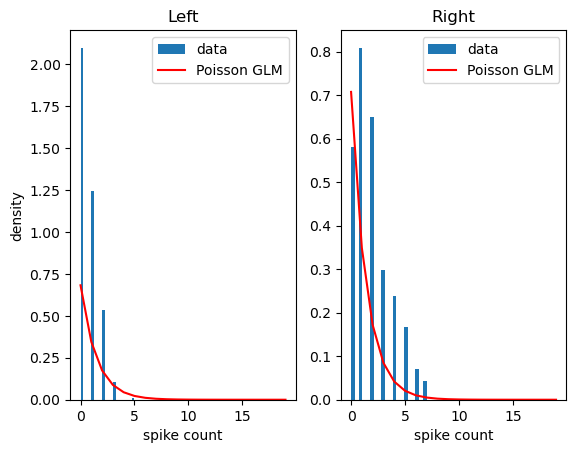

In [31]:
ExpectedCount_Response = np.zeros(2)

# expected value of counts for leftward responses
ExpectedCount_Response[0] = np.exp(res.params[0])

# expected value of counts for rightward responses
ExpectedCount_Response[1] = np.exp(res.params[0] + res.params[1])

# loop through left/right responses
for r in range(2):
    # corresponding subplot
    plt.subplot(1,2,r+1)
    
    # select corresponding trials
    mask = df.Response==r
    
    #corresponding spike counts
    SpikeCountResp = df.SpikeCount[mask]
    
    # plot experimental distribution of counts
    plt.hist(SpikeCountResp, bins=20, density=True, label='data')
    
    # range of values to plot for exponential distribution
    xx = range(20)
    
    # scale is inverse of expected count
    scale = 1/ExpectedCount_Response[r]
    
    #probability of count according to Poisson distribution 
    pPoisson = expon.pdf(xx, scale=scale)
    
    # plot Poisson prediction
    plt.plot(xx, pPoisson, 'r-',label='Poisson GLM');
    
    plt.xlabel('spike count');
    if r==0: plt.ylabel('density')  
    plt.legend();
    plt.title(RespLabel[r]);

**Interpret.**

*The fit is ok but far from perfect. There is probably more going on that the neuron just activating for rightward responses.*